<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/CNN%20Model/MNIST_using_CNN_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import idx2numpy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available else "cpu")
DEVICE

device(type='cuda')

In [32]:
test_images = idx2numpy.convert_from_file('../t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file('../t10k-labels.idx1-ubyte')
train_images = idx2numpy.convert_from_file('../train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('../train-labels.idx1-ubyte')

In [33]:
test_images = torch.Tensor(test_images).unsqueeze(1)
test_labels = torch.LongTensor(test_labels)
train_images = torch.Tensor(train_images).unsqueeze(1)
train_labels = torch.LongTensor(train_labels)

In [34]:
test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)
train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)

In [35]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

label: 4


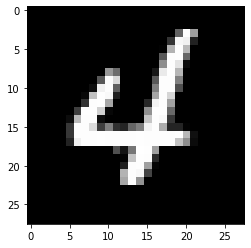

In [36]:
plt.imshow(train_images[2589].squeeze(), cmap='gray')
print('label:',train_labels[2589].item())

In [37]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=4*4*12, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):

        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2)

        t = t.reshape(-1, 4*4*12)
        # t.flatten(start_dim=1)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.fc2(t)
        t = F.relu(t)

        t = self.out(t)

        # t = F.softmax(t)
        # https://discord.com/channels/707642124081823765/707642125050839053/794623821663174667

        return t

In [41]:
network = Network()
network.to(DEVICE)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [42]:
# def Model(dataset, batch_size=100, lr=0.01, iterations=10):
batch_size=100
lr=0.002
iterations=50
loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
optimizer = optim.Adam(network.parameters(), lr=lr)

batch_loss = []
correct = []

for epoch in range(iterations):

    epoch_loss = 0
    epoch_correct = 0
    for batch in loader:
        images, labels = batch
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_correct = preds.argmax(dim=1).eq(labels).sum().item()
        epoch_correct += batch_correct

        batch_loss.append(loss.item())
        correct.append(batch_correct)
    
    print('Epoch:', epoch, 'Loss:', epoch_loss, 'Accuracy:', epoch_correct/600)

Epoch: 0 Loss: 113.14091622596607 Accuracy: 94.25333333333333
Epoch: 1 Loss: 42.208260844039614 Accuracy: 97.82833333333333
Epoch: 2 Loss: 32.1909788475823 Accuracy: 98.325
Epoch: 3 Loss: 27.980155930879846 Accuracy: 98.63333333333334
Epoch: 4 Loss: 27.476427561807213 Accuracy: 98.64333333333333
Epoch: 5 Loss: 25.219726547933533 Accuracy: 98.73666666666666
Epoch: 6 Loss: 22.234924466869415 Accuracy: 98.88333333333334
Epoch: 7 Loss: 22.121395733964164 Accuracy: 98.91666666666667
Epoch: 8 Loss: 21.76725953165851 Accuracy: 98.92166666666667
Epoch: 9 Loss: 19.445616837803755 Accuracy: 99.07666666666667
Epoch: 10 Loss: 18.532085501577967 Accuracy: 99.12333333333333
Epoch: 11 Loss: 21.659755386883262 Accuracy: 98.97333333333333
Epoch: 12 Loss: 17.38552808456734 Accuracy: 99.15833333333333
Epoch: 13 Loss: 15.784962758082656 Accuracy: 99.195
Epoch: 14 Loss: 22.169243920910503 Accuracy: 99.03
Epoch: 15 Loss: 14.755914668847254 Accuracy: 99.28166666666667
Epoch: 16 Loss: 16.207333667142848 Accur

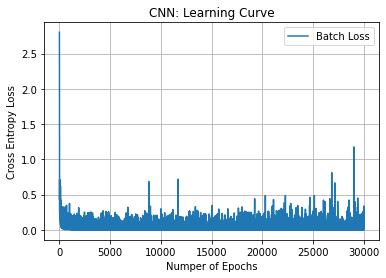

In [51]:
plt.plot(np.arange(30000), batch_loss, label="Batch Loss")
plt.grid()
plt.title("CNN: Learning Curve")
plt.legend()
plt.xlabel("Numper of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.savefig("CNNCost.jpeg")
plt.show()

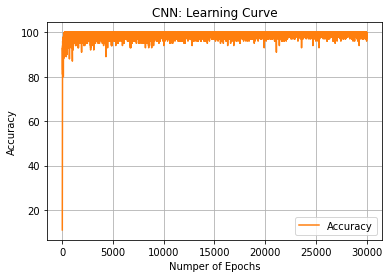

In [58]:
plt.plot(np.arange(30000), correct, label="Accuracy", c="tab:orange")
plt.grid()
plt.title("CNN: Learning Curve")
plt.legend()
plt.xlabel("Numper of Epochs")
plt.ylabel("Accuracy")
plt.savefig("CNNacc.jpeg")
plt.show()

In [59]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [61]:
network.cpu()
train_preds = get_all_preds(network, loader)
print(train_preds.argmax(1).eq(train_labels).sum().item(), 'correctly labeled out of', len(train_images))
print('Accuracy on Train Set:', train_preds.argmax(1).eq(train_labels).sum().item() / len(train_images) * 100)

59641 correctly labeled out of 60000
Accuracy on Train Set: 99.40166666666667


In [62]:
train_preds.argmax(1).eq(train_labels).sum() / len(train_images)

tensor(0.9940)

In [63]:
test_preds = get_all_preds(network, test_loader)
print(test_preds.argmax(1).eq(test_labels).sum().item(), 'correctly labeled out of', len(test_images))
print('Accuracy on Train Set:', test_preds.argmax(1).eq(test_labels).sum().item() / len(test_images) * 100)

9859 correctly labeled out of 10000
Accuracy on Train Set: 98.59


In [64]:
test_preds.argmax(1).eq(test_labels).sum() 

tensor(9859)

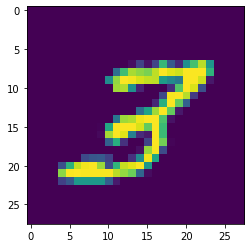

The model predicts 3


In [65]:
i = 9925
plt.imshow(test_images[i].reshape(28,28))
plt.show()
print('The model predicts', test_preds.argmax(1)[i].item())

In [73]:
# Saving the state_dict of Model
PATH = 'MNIST_cnn_model.pth'
torch.save(network.state_dict(), PATH)

In [171]:
# Loadel the saved Model
# the_network = Network()
# the_network.load_state_dict(torch.load(PATH))
# the_network.eval()

<All keys matched successfully>

-------------------------------------------------------------------

